In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

[-85. -75. -65. -55. -45. -35. -25. -15.  -5.   5.  15.  25.  35.  45.
  55.  65.  75.  85.]
68.1292
h2o shape (444, 18)
[248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427
 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442]
(array([ 6,  7,  8,  9, 10, 11]),) lat indices


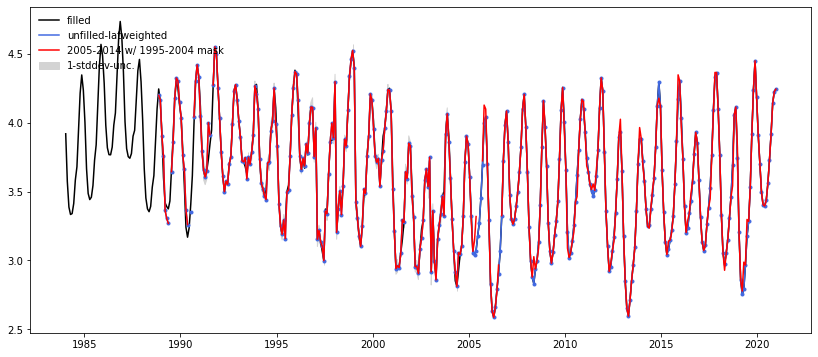

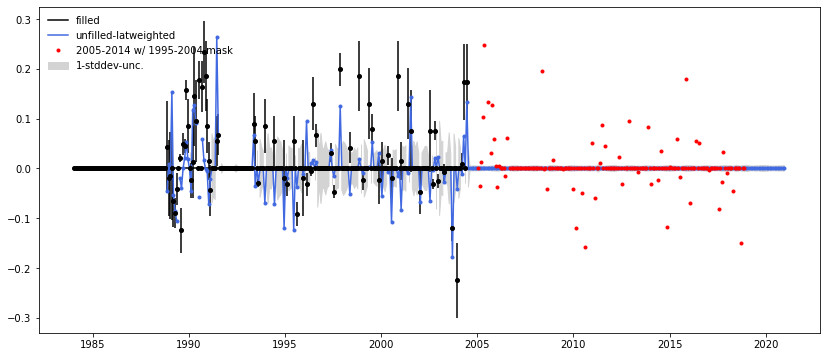

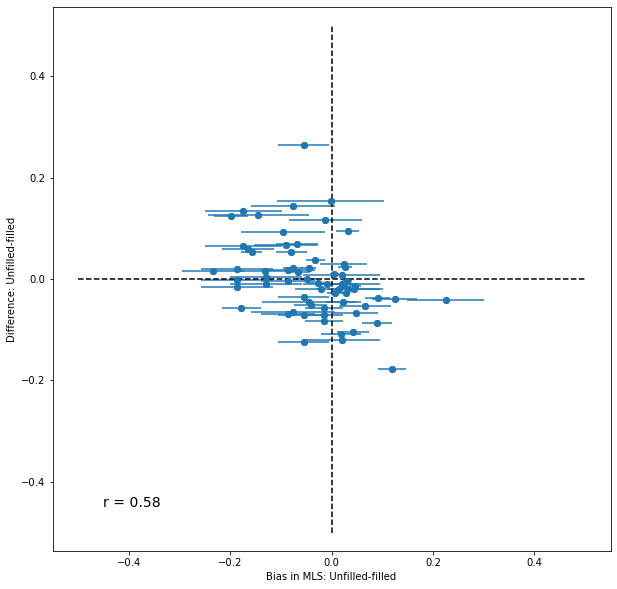

<Figure size 1080x540 with 0 Axes>

In [3]:
# prep predictor observations H2O
# created: 7 October 2021 by Will Ball; only minor modifications later by Peer Nowack

import numpy as np
import matplotlib.pyplot as plt
import netCDF4

#Convertor to Julian date
from astropy.time import Time
#from astropy.time import TimeJD
from datetime import datetime
def convertjd(yr, mn, dy):
    Nt = len(yr)
    yr = np.array(yr)
    mn = np.array(mn)    
    dy = np.array(dy)    
    jd = np.zeros(Nt)
    for t in np.arange(Nt):
        jdtmp = Time(datetime(int(yr[t]), int(mn[t]), int(dy[t]), 12, 0, 0))
        jdtmp.format='jd'
        jd[t] = jdtmp.value
    return jd

#%%
#Input file
#-----------
fn = './data/swoosh/swoosh-v02.7-198401-202202-latpress-10deg-L31.nc'
nt_paper=444
data = netCDF4.Dataset(fn)
time = np.array(data['time'][:nt_paper])                    #time index
yrtime = np.array(data['yrtime'][:nt_paper])                #fractional time of year - centred on 15th
latitude = np.array(data['lat'][:])
print(latitude)
#central latitude, 10deg [-85, -75...]
levs = np.array(data['level'][:])
# print(levs)
# print(levs[8])
#pressure levels; 8 = 68 hPa
h2o = np.array(data['combinedh2oq'][:nt_paper])             #h2o w/gaps
h2of = np.array(data['combinedanomfillh2oq'][:nt_paper])    #h2o filled
h2oe = np.array(data['combinedh2ostddev'][:nt_paper])       #h2o stddev w/gaps
h2on = np.array(data['combinedh2on'][:nt_paper])            #h2o n obs per bin
h2oel = np.array(data['combinedh2olat'][:nt_paper])         #h2o mean obs latitude
h2oet = np.array(data['combinednomlsh2otime'][:nt_paper])   #h2o mean obs time - JD

# SWITCH h2oe == stddev --> h2oe/h2on == stderr
h2oe = h2oe/np.sqrt(h2on)


# Calculate Julian date (important for delta-wrt-h2oet)
#------------------------------------------------------
startyr = 1984.; endyr = 2020
### 1/24 to define mid-month
timeyr = np.arange(startyr,endyr+1,1/12.)+1/24.
yr = np.zeros(len(timeyr))
mn = np.zeros(len(timeyr))
dy = np.zeros(len(timeyr))+15.
for yy in range(int(endyr)-int(startyr)+1):
    yr[yy*12:(yy+1)*12] = yy+startyr
    mn[yy*12:(yy+1)*12] = np.arange(1,12+1,1)
timejd = convertjd(yr, mn, dy)

# "-3" is the  missing Oct-Dec period in 2020; v2.6 has upto Sept 2021; v2.7 to 2020.
timejd = timejd[:] #this corresponds to 15th of the month
timeyr = timeyr[:] #exactly the centre of the month; yrtime (from SWOOSH) is 15th / THIS IS A CHECK

#We take the MLS period from October 2004 [index = 248]; not September because Obs begin on 13th Sept.
#We assess all data up to 246; note 247 is partial MLS period, so fully filled.

# select out pressure level --> levs[8] = 68 hPa
print(levs[8])
plev = 8; levs = levs[8]

h2o = h2o[:,plev,:]; h2of = h2of[:,plev,:]; h2oe = h2oe[:,plev,:]
h2on = h2on[:,plev,:]; h2oel = h2oel[:,plev,:]; h2oet = h2oet[:,plev,:]

#cut out MLS period
mlsind=np.array([248,443])
print('h2o shape',h2o.shape)
print(time[248:443])
mlsh2o = h2o[mlsind[0]:mlsind[1],:]; mlsh2of = h2of[mlsind[0]:mlsind[1],:]; mlsh2oe = h2oe[mlsind[0]:mlsind[1],:]
mlsh2on = h2on[mlsind[0]:mlsind[1],:]; mlsh2oel = h2oel[mlsind[0]:mlsind[1],:]; mlsh2oet = h2oet[mlsind[0]:mlsind[1],:]
mlstimeyr = timeyr[mlsind[0]:mlsind[1]]; mlsyrtime = yrtime[mlsind[0]:mlsind[1]]; mlstimejd = timejd[mlsind[0]:mlsind[1]]
#index the months by months value, Jan = 0
mlsmonind = (np.arange(len(mlstimeyr))+9) % 12

#cut out evaluation period
evaind=np.array([0,246])
evah2o = h2o[evaind[0]:evaind[1],:]; evah2of = h2of[evaind[0]:evaind[1],:]; evah2oe = h2oe[evaind[0]:evaind[1],:]
evah2on = h2on[evaind[0]:evaind[1],:]; evah2oel = h2oel[evaind[0]:evaind[1],:]; evah2oet = h2oet[evaind[0]:evaind[1],:]
evatimeyr = timeyr[evaind[0]:evaind[1]]; evayrtime = yrtime[evaind[0]:evaind[1]]; evatimejd = timejd[evaind[0]:evaind[1]]
#index the months by months value, Jan = 0
evamonind = (np.arange(len(evatimeyr))+0) % 12

#identify latitudes of interest
wlat = np.array(np.where((latitude >= -30) & (latitude <= 30))).flatten()

#create mask for data: 0 = no data; 1 = data present
mask = h2o/h2o; mask[np.isnan(mask)] = 0.
maskf = h2of/h2of; mask[np.isnan(mask)] = 0.

#%% Now calculate errors based on MLS period, but masks from pre-MLS
# And, calculate Filled and Unfilled 30S-30N as references
wlat = np.where((latitude >= -30) & (latitude <= 30))           # select latitude region
lat30 = latitude[wlat]  
print(wlat,'lat indices')
# resize arrays
h2otmp = h2o[:,wlat].reshape(len(time), len(lat30))             # latitude selected region for the h2o data (UNFILLED)
h2oftmp = h2of[:,wlat].reshape(len(time), len(lat30))           # latitude selected region for the h2o data (FILLED)
h2oetmp = h2oe[:,wlat].reshape(len(time), len(lat30))           # latitude selected region for the h2o errors (UNFILLED)

masktmp = h2otmp/h2otmp                                         # set binary values for the masks for index identifying
maskftmp = h2oftmp/h2oftmp                                      # temporary masks of latitude region of interest for (UN)FILLED data

h2otmp[np.isnan(masktmp)] = 0.                                  # get rid of Nans
h2oftmp[np.isnan(maskftmp)] = 0.
masktmp[np.isnan(masktmp)] = 0.
maskftmp[np.isnan(maskftmp)] = 0.

h2o_mlsmask = h2otmp.copy()                                     # create copies of MLS period
mask_mlsmask = masktmp.copy()

mask_mlsmask[252:431,:] = mask_mlsmask[72:251,:]                # (approx) replace mask during MLS period with pre MLS period

weilat = np.cos(lat30/180*np.pi)                                # latitude weighting
h2o30 = np.zeros(len(time))                                     # arrays for 30S-30N integrated data (unfilled)
h2of30 = np.zeros(len(time))                                    # arrays for 30S-30N integrated data (filled)
h2oe30sum = np.zeros(len(time))                                 # arrays for 30S-30N integrated data (sum errors)
h2oe30sumsq = np.zeros(len(time))                               # arrays for 30S-30N integrated data (squared errors)
h2o30_mlsmask = np.zeros(len(time))                             # masked MLS period with pre MLS period

#Loop through each time element and perform latitude integration
for tt in range(len(time)):
    if np.sum(weilat*masktmp[tt,:]) != 0.:
        h2o30[tt] = np.sum(weilat*masktmp[tt,:]/(np.sum(weilat*masktmp[tt,:]))*h2otmp[tt,:])
        #print(weilat, masktmp[tt,:], h2otmp[tt,:], h2o30[tt])
        h2oe30sum[tt] = np.sum(weilat*masktmp[tt,:]/(np.sum(weilat*masktmp[tt,:]))*h2oetmp[tt,:])
        h2oe30sumsq[tt] = np.sqrt(np.sum(weilat*masktmp[tt,:]/(np.sum(weilat*masktmp[tt,:]))*h2oetmp[tt,:]**2))
    if np.sum(weilat*maskftmp[tt,:]) != 0.:
        h2of30[tt] = np.sum(weilat*maskftmp[tt,:]/(np.sum(weilat*maskftmp[tt,:]))*h2oftmp[tt,:])
    if np.sum(weilat*mask_mlsmask[tt,:]) != 0.:
        h2o30_mlsmask[tt] = np.sum(weilat*mask_mlsmask[tt,:]/(np.sum(weilat*mask_mlsmask[tt,:]))*h2otmp[tt,:])

#Place NaNs back in (for plotting)
h2o30[np.where(h2o30 == 0)] = float("NaN")
h2of30[np.where(h2of30 == 0)] = float("NaN")
h2oe30sum[np.where(h2oe30sum == 0)] = float("NaN")
h2oe30sumsq[np.where(h2oe30sumsq == 0)] = float("NaN")
h2o30_mlsmask[np.where(h2o30_mlsmask == 0)] = float("NaN")

#%% Perform integrations over similar months for all of MLS period using mask for each month during pre-MLS period

delint30mls = np.zeros((len(evamonind), 2)) # bias introduced by sampling MLS data with missing latitudes
count =-1                                   # check for first iteration
# print('evamonind', evatimeyr)
for ii in range(len(evatimeyr)):            # iterate over each index of the period under evaluation (pre MLS)
    if np.sum(mask[ii,wlat]) != 0.: ###goes into loop whenever at least one element is not equal to zero
        count += 1
        evaind = evamonind[ii]
        wevamlsind = np.array(np.where(mlsmonind == evaind)).flatten() # where are the missing latitudes?
        
        # renormalise the latitude weighting for missing values
        weilat = np.cos(latitude/180*np.pi)*mask[ii,:]; weilat[wlat] = weilat[wlat]/np.sum(weilat[wlat])
        int30mlsmask = mlsh2o[:,wlat[:]]
        int30mlsmask = int30mlsmask[wevamlsind[:],:]
        int30mlsmask = np.matmul(int30mlsmask, weilat[wlat])
        
        # integrate when no data missing
        weilat = np.cos(latitude/180*np.pi); weilat[wlat] = weilat[wlat]/np.sum(weilat[wlat])
        int30mls = mlsh2o[:,wlat[:]]
        int30mls = int30mls[wevamlsind[:],:]
        int30mls = np.matmul(int30mls, weilat[wlat])

        # mean + stddev of bias
        delint30mls[ii,0] = np.mean(int30mls-int30mlsmask)
        delint30mls[ii,1] = np.std(int30mls-int30mlsmask)        
        
#%% Plot figure of various integrated timeseries
plt.figure(figsize=(14, 6))
plt.plot(timeyr, h2of30,color='k', label='filled')
plt.fill_between(timeyr, h2of30+h2oe30sumsq, h2of30-h2oe30sumsq, color='lightgray', label='1-stddev-unc.')
plt.plot(timeyr, h2o30,color='royalblue', label='unfilled-latweighted')
plt.plot(timeyr, h2o30,'.',color='royalblue')
plt.plot(timeyr, h2o30_mlsmask, color='red', label = '2005-2014 w/ 1995-2004 mask')
plt.legend(loc='upper left', frameon=False)
plt.show()
#%% Plot figure of various integrated timeseries, relative to filled timeseries
plt.figure(figsize=(14, 6))
ind1 = 252
ind2 = 419
plt.plot(timeyr, h2of30 -h2of30,color='k', label='filled')
#plt.plot(h2of30+h2oe30sumsq, '--',color='k')
#plt.plot(h2of30-h2oe30sumsq, '--',color='k')
#plt.fill_between(timeyr, h2of30+h2oe30sum, h2of30-h2oe30sum, color='gray')
plt.fill_between(timeyr, h2of30+h2oe30sumsq-h2of30, h2of30-h2oe30sumsq-h2of30, color='lightgray', label='1-stddev-unc.')
plt.plot(timeyr, h2o30-h2of30,color='royalblue', label='unfilled-latweighted')
plt.plot(timeyr, h2o30-h2of30,'.',color='royalblue')
#plt.plot(timeyr, h2o30_mlsmask-h2of30, color='red', label = '2005-2014 w/ 1995-2004 mask')
plt.plot(timeyr[ind1:ind2], h2o30_mlsmask[ind1:ind2]-h2of30[ind1:ind2],'.',color='red', label = '2005-2014 w/ 1995-2004 mask')
plt.legend(loc='upper left', frameon=False)
single = h2o30_mlsmask[ind1:ind2]-h2of30[ind1:ind2]

plt.errorbar(evatimeyr, -delint30mls[:,0], delint30mls[:,1], marker='o', linestyle='None', ms=4,color='k')
#%% Scatter plot between MLS estimated biases and difference between filled and unfilled data

#plt.scatter(delint30mls[:,0], h2o30[0:246]-h2of30[0:246])
plt.figure(figsize=(10, 10))
axrng = 0.5
notzero = np.array(np.where(delint30mls[:,0] != 0.))
plt.scatter(delint30mls[notzero,0], h2o30[notzero]-h2of30[notzero])
plt.errorbar(delint30mls[notzero,0].flatten(), h2o30[notzero].flatten()-h2of30[notzero].flatten(), xerr=-delint30mls[notzero,1].flatten(), fmt="o")
# print('test',h2o30[notzero].shape,delint30mls[notzero,0].shape)
# print(np.corrcoef(delint30mls[notzero,0], h2o30[notzero]-h2of30[notzero]))
plt.plot([0,0],[-axrng,axrng], linestyle='--', color='k')
plt.plot([-axrng,axrng],[0,0], linestyle='--', color='k')
plt.xlim(-axrng, axrng)
plt.ylim(-axrng, axrng)
plt.xlabel("Bias in MLS: Unfilled-filled")
plt.ylabel("Difference: Unfilled-filled")
plt.axis('equal')
plt.text(-0.45, -0.45, "r = 0.58", fontsize=14)
plt.show()

#%%
# Draw 50 samples
n = 50                 # number of output samples
scale_se = 1.          # scale the standard error on all the data
scale_bias_sd = 1.     # scale the bias estimated from missing data during MLS period

bias_sd = np.zeros(len(h2of30)); bias_sd[0:len(delint30mls[:,1].flatten())] = delint30mls[:,1].flatten()
np.random.seed(1234)
samples = np.zeros((len(h2of30), n))
for nn in range(n):
    samples[:,nn] = h2of30+np.random.normal(0., bias_sd)*scale_bias_sd+np.random.normal(0., h2oe30sumsq)*scale_se
# PLOT CHECK
#    plt.plot(samples[:,nn]-samples[:,0])
plt.figure(figsize=(15, 7.5))
plt.show()

# Sample time series saved as "samples"


# Save out new dataset
# Create variables
Nt = len(timeyr)
sampindex = np.arange(0,n,1)

output = netCDF4.Dataset('./data/swoosh/SWOOSH_samples_scaleSE_1.0_scaleB_1.0_nsamples_50_aura5_finalNatGeo.nc', 'w')
output.createDimension('time', Nt)
output.createDimension('nsamples', n)

TIME = output.createVariable('time', float, ('time'), zlib=True)
SAMPIND = output.createVariable('samples_index', float, ('nsamples'), zlib=True)
SAMPS = output.createVariable('samples', float, ('time', 'nsamples'), zlib=True)

# Assign variables
TIME[:] = timeyr
SAMPIND[:] = sampindex
SAMPS[:,:] = samples

# Close the .nc
output.close()

In [4]:
!python -V 

Python 3.8.8
